## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import yaml

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
from dataset_loader import *
from word_embed import *
from models.attention import *
from models.non_attention import *
from models.addns import *
from train_pred import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import warnings
warnings.filterwarnings("ignore")

### Converting XML to Txt

In [5]:
!py process_dataset.py --category rest --split train
!py process_dataset.py --category rest --split test

[+] Done



0it [00:00, ?it/s]
3044it [00:00, 504682.64it/s]


[+] Done



0it [00:00, ?it/s]
800it [00:00, 800439.69it/s]


### Converting Txt to pkl

In [6]:
!py text_dataset.py --category rest

Max Context Len  78
[+] Data Saved
[+] Data Saved


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Word Embeddings

In [7]:
word2id = get_word_info('rest')
embed_size = 300
word_embeddings = load_word_embeddings(embed_size, word2id)

100%|█████████████████████████████████████████████████████████████████████| 2196018/2196018 [02:36<00:00, 14055.96it/s]


### Preparing Dataset

In [8]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

train_store_path = config['rest_train_pkl']
test_store_path = config['rest_test_pkl']

train_store = joblib.load(train_store_path)
test_store = joblib.load(test_store_path)

train_dataset = TextDataset(train_store)
test_dataset = TextDataset(test_store)

### Classification

In [9]:
# Hyper Parameters
embed_size = 300
batch_size = 128
epochs = 7
hidden_size = 300
output_dims = 3
learning_rate = 0.001
l2_reg_fact = 1e-6
clip = 3
dropout = 0.5
vocab_size = len(word2id)

In [10]:
aspects, contexts, _ , _, _ = train_store

max_aspect_len = aspects.shape[1]
max_context_len = contexts.shape[1]

In [11]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = len(test_dataset), shuffle = False)

#### Attention Model

In [12]:
attention_model = AttentionModel(embed_size, vocab_size, word_embeddings,
                                hidden_size, l2_reg_fact, max_aspect_len, max_context_len, output_dims)

In [13]:
attn_model_trainer = Trainer(attention_model, train_loader, test_loader, learning_rate, l2_reg_fact, epochs, clip)

In [14]:
train_losses, val_losses, train_accs, val_accs = attn_model_trainer.train_and_get_losses()

For epoch ==>  1
Train Loss ==> 0.9484808999916603 || Val Loss ==> 0.8135884404182434
Train Acc ==> 0.6098599137931034 || Val Acc ==> 0.7053571581840515

For epoch ==>  2
Train Loss ==> 0.7731014510680889 || Val Loss ==> 0.7337866425514221
Train Acc ==> 0.7045977004643142 || Val Acc ==> 0.7294642567634583

For epoch ==>  3
Train Loss ==> 0.6847184505955927 || Val Loss ==> 0.6776189804077148
Train Acc ==> 0.7602729891908578 || Val Acc ==> 0.7732143044471741

For epoch ==>  4
Train Loss ==> 0.6063739513528759 || Val Loss ==> 0.6706105470657349
Train Acc ==> 0.8158584763263831 || Val Acc ==> 0.7794642686843872

For epoch ==>  5
Train Loss ==> 0.5593416403079855 || Val Loss ==> 0.656846284866333
Train Acc ==> 0.8442349137931031 || Val Acc ==> 0.7901785612106323

For epoch ==>  6
Train Loss ==> 0.5282548193273873 || Val Loss ==> 0.6640904545783997
Train Acc ==> 0.860488506432237 || Val Acc ==> 0.7857142925262451

For epoch ==>  7
Train Loss ==> 0.5007600003275378 || Val Loss ==> 0.656161665

##### Loss Plots

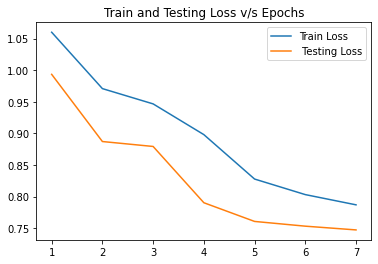

In [27]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_losses, label = 'Train Loss')
plt.plot(epoch_range, val_losses, label =' Testing Loss')
plt.title("Train and Testing Loss v/s Epochs")
plt.legend()
plt.show()

##### Accuracy Plots

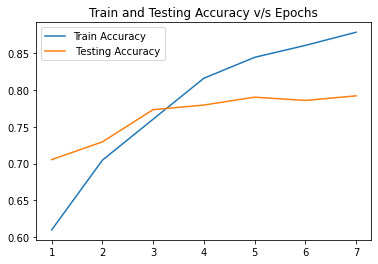

In [16]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_accs, label = 'Train Accuracy')
plt.plot(epoch_range, val_accs, label =' Testing Accuracy')
plt.title("Train and Testing Accuracy v/s Epochs")
plt.legend()
plt.show()

##### Save Model

In [17]:
torch.save(attention_model, './model_state/rest_attn.pth')

##### Load Model

In [18]:
attention_model = torch.load('./model_state/rest_attn.pth')

##### Visualizing attention

In [80]:
import nltk
from nltk.tokenize import word_tokenize

aspects, contexts, labels, len_aspects, len_contexts = test_store

vis_aspect, vis_context, vis_label, vis_len_aspect, vis_len_context = aspects[130:135], contexts[130:135], labels[130:135], len_aspects[130:135], len_contexts[130:135]

vis_file = config['rest_test_dataset_txt']
vis_test_file = open(vis_file, 'r')

vis_lines = vis_test_file.readlines()
lines_read = 0

vis_aspect_real= []
vis_context_real = []

for i in range(390, len(vis_lines), 3):
    context = vis_lines[i]
    aspect = vis_lines[i+1]
    
    vis_aspect_real.append(word_tokenize(aspect))
    vis_context_real.append(word_tokenize(context))
    
    lines_read += 1
    
    if lines_read == 5:
        break
print(len(vis_context_real[0]))
print(vis_context[0])

vis_data = (vis_aspect, vis_context, vis_label, vis_len_aspect, vis_len_context)
temp_dataset = TextDataset(vis_data)
temp_data_loader = DataLoader(dataset = temp_dataset, batch_size = 5, shuffle = False)

attention_model.set_attn_store(True)
device = torch.device('cpu')

attention_model.eval()
with torch.no_grad():
    for data in temp_data_loader:
        asp, con, lab, asp_mask, con_mask = data
        asp = asp.to(device)
        con = con.to(device)
        lab = lab.to(device)
        asp_mask = asp_mask.to(device)
        con_mask = con_mask.to(device)

        store = (asp, con, asp_mask, con_mask)
        attention_model(store)

con_attn = attention_model.stored_context_attn.clone()
asp_attn = attention_model.stored_aspect_attn.clone()

con_attn = con_attn.numpy()
asp_attn = asp_attn.numpy()

con_attn_store = []
asp_attn_store = []

for i in range(0, len(con_attn)):
    con_attn_temp = con_attn[i]
    con_attn_temp = con_attn_temp[0:len(vis_context_real[i]) ]
    con_attn_store.append(con_attn_temp.tolist())


for i in range(0, len(asp_attn)):
    asp_attn_temp = asp_attn[i]
    asp_attn_temp = asp_attn_temp[0:len(vis_aspect_real[i])]
    asp_attn_store.append(asp_attn_temp.tolist())

for i in range(0, len(vis_context_real)):
    real_op = []
    attn_op = []
    for item in vis_context_real[i]:
        if type(item) == list:
            real_op.extend(item)
        else:
            real_op.append(item)
            
    for item in con_attn_store[i]:
        if type(item) == list:
            attn_op.extend(item)
        else:
            attn_op.append(item)
    vis_context_real[i] = real_op
    con_attn_store[i] = attn_op


8
[  1 998   7  35 847   4 247   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


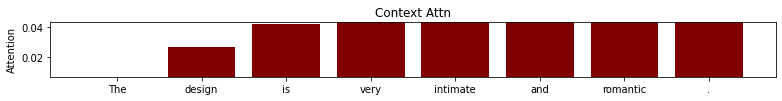

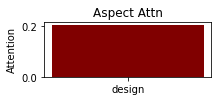

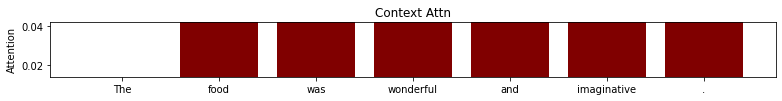

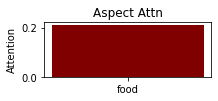

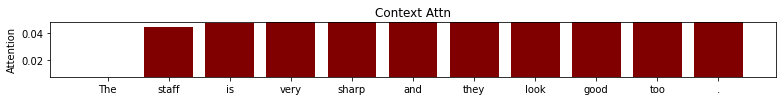

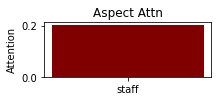

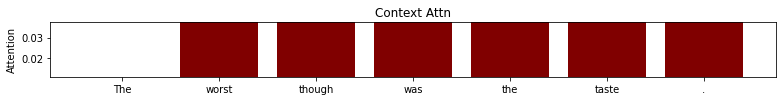

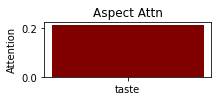

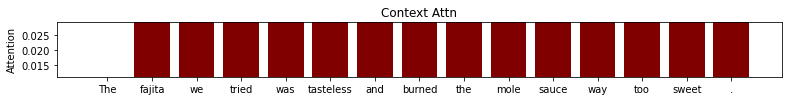

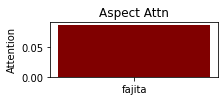

In [81]:
for i in range(0, 5):
    plt.figure(figsize = (13, 1))
    bot = min(con_attn_store[i])
    top = max(con_attn_store[i])
    plt.bar(vis_context_real[i],con_attn_store[i], color = 'maroon')
    plt.ylabel('Attention')
    
    plt.ylim(bot,top)
    plt.title('Context Attn')
    plt.show()
    
    plt.figure(figsize = (3, 1))
    plt.bar(vis_aspect_real[i], asp_attn_store[i], color = 'maroon')
    plt.ylabel('Attention')
    plt.title('Aspect Attn')
    plt.show()
    
    

#### Non-Attention Model

In [21]:
non_attention_model = NonAttentionModel(embed_size, vocab_size, word_embeddings,
                                hidden_size, l2_reg_fact, max_aspect_len, max_context_len, output_dims)

In [22]:
non_attn_model_trainer = Trainer(non_attention_model, train_loader, test_loader, learning_rate/10, l2_reg_fact, epochs, clip)

In [23]:
train_losses, val_losses, train_accs, val_accs = non_attn_model_trainer.train_and_get_losses()

For epoch ==>  1
Train Loss ==> 1.0600314571939666 || Val Loss ==> 0.9933981895446777
Train Acc ==> 0.5793283039125905 || Val Acc ==> 0.6749999761581421

For epoch ==>  2
Train Loss ==> 0.9708284221846482 || Val Loss ==> 0.8870799541473389
Train Acc ==> 0.6254849137931034 || Val Acc ==> 0.6749999761581421

For epoch ==>  3
Train Loss ==> 0.9466430955919726 || Val Loss ==> 0.879277229309082
Train Acc ==> 0.6208153739057739 || Val Acc ==> 0.6749999761581421

For epoch ==>  4
Train Loss ==> 0.8980053149420639 || Val Loss ==> 0.7902297973632812
Train Acc ==> 0.6254849137931034 || Val Acc ==> 0.6749999761581421

For epoch ==>  5
Train Loss ==> 0.8277150865258842 || Val Loss ==> 0.760632336139679
Train Acc ==> 0.6282686788460304 || Val Acc ==> 0.6758928537368775

For epoch ==>  6
Train Loss ==> 0.8030863897553806 || Val Loss ==> 0.7531311511993408
Train Acc ==> 0.6339260064322374 || Val Acc ==> 0.6803571224212647

For epoch ==>  7
Train Loss ==> 0.7868925805749565 || Val Loss ==> 0.747205972

##### Loss Plots

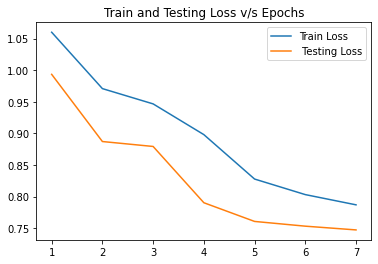

In [24]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_losses, label = 'Train Loss')
plt.plot(epoch_range, val_losses, label =' Testing Loss')
plt.title("Train and Testing Loss v/s Epochs")
plt.legend()
plt.show()

##### Accuracy Plots

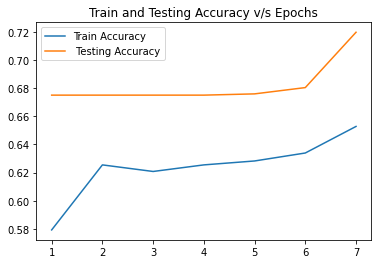

In [25]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_accs, label = 'Train Accuracy')
plt.plot(epoch_range, val_accs, label =' Testing Accuracy')
plt.title("Train and Testing Accuracy v/s Epochs")
plt.legend()
plt.show()

##### Save Model

In [26]:
torch.save(non_attention_model, './model_state/rest_non_attn.pth')